### Initialization

Import modules

In [1]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
import elvet
import matplotlib.pyplot as plt
import pandas as pd

from ewpt.model import model

Metal device set to: Apple M1
 Elvet: If you use Elvet in research, please cite arXix:2103.14575


Define a model with large portal coupling, on-shell scheme, and no large-T-expansions for $J_B, J_F$ 

In [2]:
params1 = {'g1': 0.4632, 'g2': 0.6485, 'yt': 0.92849, 'yb': 0.0167, 'mHsq': -1.22559, 'mSsq': 6.2867, 'lmbd': 0.258047, 'lmbd_SH': 10.52, 'lmbd_S': 1, 'N': 0.5, 'vevh': 3.08204}

model1 = model(params1, bsm = True, eft = False)

Check field list for the model

In [3]:
for field in model1.field_object_list:
    print(field.name)

sm_higgs
goldstone
bsm_scalar
w_boson_t
w_boson_l
z_boson_t
z_boson_l
photon_l
t_quark
b_quark


Potential plots near $T_c$

In [4]:
h1 = elvet.box((0.0, 3.0, 3000)) 
h2 = elvet.box((0.0, 4.0, 4000))

h01 = tf.zeros((len(h1), 1), dtype=tf.float32)
h02 = tf.zeros((len(h2), 1), dtype=tf.float32)

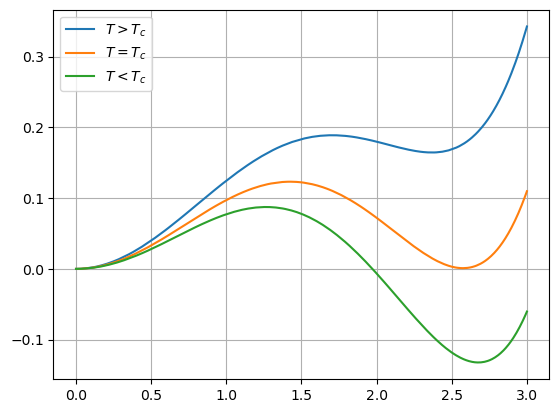

In [5]:
plt.plot(h1, model1.total_potential(h1, 105, **{'scheme':"On-shell"}, large_T_approx=False) - model1.total_potential(h01, 105, **{'scheme':"On-shell"}, large_T_approx=False), label="$T>T_c$" )
plt.plot(h1, model1.total_potential(h1, 99.4, **{'scheme':"On-shell"}, large_T_approx=False) - model1.total_potential(h01, 99.4, **{'scheme':"On-shell"}, large_T_approx=False), label="$T=T_c$" )
plt.plot(h1, model1.total_potential(h1, 95, **{'scheme':"On-shell"}, large_T_approx=False) - model1.total_potential(h01, 95, **{'scheme':"On-shell"}, large_T_approx=False), label="$T<T_c$" )
plt.grid(True)
plt.legend()

Envelope functions for further use of $V(h,T)$ and $dV/dh$

In [6]:
def V(h,T):
    h1 = tf.cast(h, tf.float32)
    h0 = tf.zeros((len(h1), 1), dtype=tf.float32)
    
    return (model1.total_potential(h1, T, **{'scheme':"On-shell"}, large_T_approx=False) - model1.total_potential(h0, T, **{'scheme':"On-shell"}, large_T_approx=False) ) 

In [7]:
def dV_dh(h,T):
    h1 = tf.cast(h, tf.float32)
    
    return model1.total_potential_deriv(h1, T, **{'scheme':"On-shell"}, large_T_approx=False)

### Solving the differential equation using Elvet

In [10]:

full_domain1 = elvet.box((0.01, 10, 1000))

# boundary condition for only the first run, with a guessed value of h(0)

bcs1 = (
    elvet.BC(0.01, lambda r, h, dh, d2h: h - 2.7),
    elvet.BC(0.01, lambda r, h, dh, d2h: dh),
    elvet.BC(10, lambda r, h, dh, d2h: h),
    elvet.BC(10, lambda r, h, dh, d2h: dh)
)

# boundary condition for subsequent runs, with unknown h(0)

bcs2 = (
    elvet.BC(0.01, lambda r, h, dh, d2h: dh),
    elvet.BC(10, lambda r, h, dh, d2h: h),
    elvet.BC(10, lambda r, h, dh, d2h: dh)
)


# differential equation for single step phase transition - no vev for the bsm scalar

def eqnT(r, h, dh, d2h):
    
    return d2h + (2/r)*dh  - dV_dh(h,95)

In [ ]:
result_1 = elvet.solver(eqnT, bcs1, domain=full_domain1, model=elvet.nn(1, 10, 10, 10, 1), epochs=10000, verbose=True, 
                        metrics=elvet.utils.metrics.WatchLR(True), 
                        callbacks=(elvet.utils.callbacks.EarlyStopping(min_loss=1e-6), 
                                   elvet.utils.callbacks.TerminateIf(NaN=True, Inf=True, strictly_increasing=False),
                                   elvet.utils.LRschedulers.ReduceLROnPlateau(check_every=1000, min_lr=1e-8, scale=0.9, 
                                                                              min_improvement_rate=0.01, store_lr=True), 
                                    ))

import elvet.plotting

elvet.plotting.plot_prediction(result_1)
elvet.plotting.plot_losses(result_1)

 Elvet: epoch = 1, loss = 1.13e+06, lr = 1.00e-03, elapsed time = 00:00:15


Save the weights

In [ ]:
result_1.save_model_weights("Weights/run1.h5", overwrite=True)